In [2]:
from random import Random
import numpy as np
import time
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

In [3]:
#####Setting environment
#================================
def generate_matrix(training_number):
    x_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
    rbf= gaussian_process.kernels.RBF()
    Kernel= rbf(x_train, x_train)
    K_y = Kernel + np.eye(training_number) * 1e-8

    x = np.ones((training_number,1), dtype = 'int')

        #Generate y vector 
    y = K_y@x

    #SVD:
    U,S,Vh = np.linalg.svd(K_y)
    c = U.T@y

    #QR:
    Q,R = np.linalg.qr(K_y)
    p = Q.T@y
    return R, p, S, c


R_m = []
p_m = []
S_m = []
c_m = []
n_matrix = []
for i in range(100, 1800, 50):
    n_matrix.append(i)
    R, p,S,c = generate_matrix(i)
    R_m.append(R)
    p_m.append(p)
    S_m.append(S)
    c_m.append(c)

In [4]:
def back_substitute(A, b):
    n = b.size
    x = np.zeros(b.shape)
    
    x[n-1] = b[n-1]/A[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = b[i]
        u = A[i,i+1:n]
        v = x[i+1:n]
        dotproduct = np.dot(u,v)
        x[i] -= dotproduct
        x[i] = x[i]/A[i,i]
    
    return x

def back_substitute2(A, b):
    n = b.size
    x = np.zeros(b.shape)
    
    x[n-1] = b[n-1]/A[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = b[i]
        for j in range(i+1,n):
            x[i] = x[i] - A[i,j]*x[j]
        
        x[i] = x[i]/A[i,i]
    
    return x

def back_substitute_diag(A, b):
    n = b.size
    b_list = b.ravel()
    x = b_list/A
    
    return x.reshape(n,1)


In [5]:
R, p,S,c = generate_matrix(30)

In [54]:
%timeit back_substitute(R, p)

222 µs ± 22.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
%timeit back_substitute2(R, p)

1.45 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
%timeit np.linalg.inv(R)@p

59.2 µs ± 5.77 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [57]:
%timeit np.linalg.solve(R, p)

27.7 µs ± 2.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [58]:
%timeit back_substitute_diag(S, c)

1.43 µs ± 16.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [59]:
%timeit np.linalg.solve(np.diag(S), c)

34.3 µs ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [60]:
###Check if the results are the same
#===========================================
print(np.allclose(back_substitute(R, p),np.linalg.solve(R, p)))
print(np.allclose(back_substitute2(R, p),np.linalg.solve(R, p)))
print(np.allclose(np.linalg.inv(R)@p,np.linalg.solve(R, p)))
print(np.allclose(back_substitute_diag(S, c),np.linalg.solve(np.diag(S), c)))

True
True
True
True


In [15]:
#####Bechmarking
#================================
import time
back_substitute_time = []
back_substitute2_time = []
back_substitute_diag_time = []
la_solve_time = []
la_solve_diag_time = []

for i in range(len(n_matrix)):
    tic1 = time.time()
    back_substitute(R_m[i],p_m[i])
    toc1 = time.time()
    back_substitute_time.append(toc1-tic1)
    
    tic2 = time.time()
    np.linalg.solve(R_m[i],p_m[i])
    toc2 = time.time()
    la_solve_time.append(toc2-tic2)



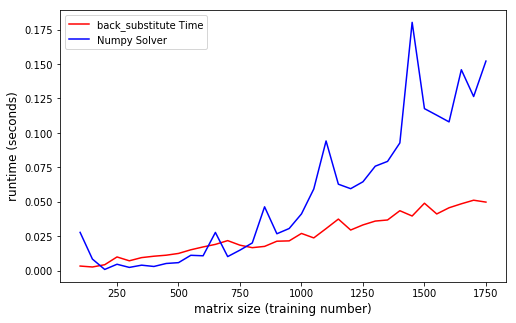

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(n_matrix,back_substitute_time, '-', c = 'r', label = 'back_substitute Time' )
plt.plot(n_matrix, la_solve_time, '-', c = 'b', label = 'Numpy Solver')
#plt.title('Runtime of Matrix Decomposition and Linear Solver,\n QR Method', fontsize = 15)
plt.ylabel('runtime (seconds)', fontsize=12)
plt.xlabel('matrix size (training number)', fontsize=12)
plt.legend()
plt.savefig('UDFvsNumpy.png')